# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [0]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
#Subset sampler for creating validation set from training set
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

#############VALIDATION####################
# percentage of training set to use as validation
valid_size = 0.2
#To prepare validation set, we use a random number generator to select indices. Floor just rounds.
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders with specific batch size, now with Sampler subarguments
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler,num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

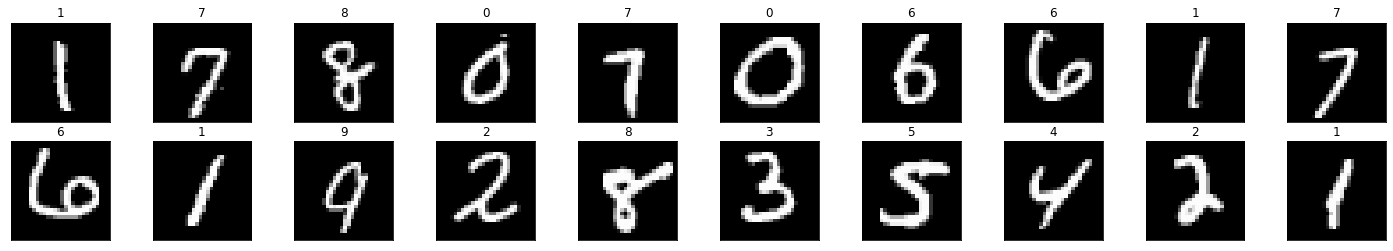

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels, plot 20 images
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail


Squeezing a tensor removes the dimensions or axes that have a length of one.
Unsqueezing a tensor adds a dimension with a length of one. We squeeze to remove meaningless values such as batch number, or empty brackets

In this case we have (1, 28, 28) ->(28, 28)


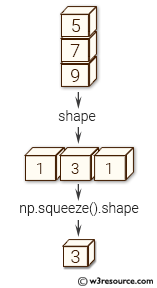

(1, 28, 28)
(28, 28)


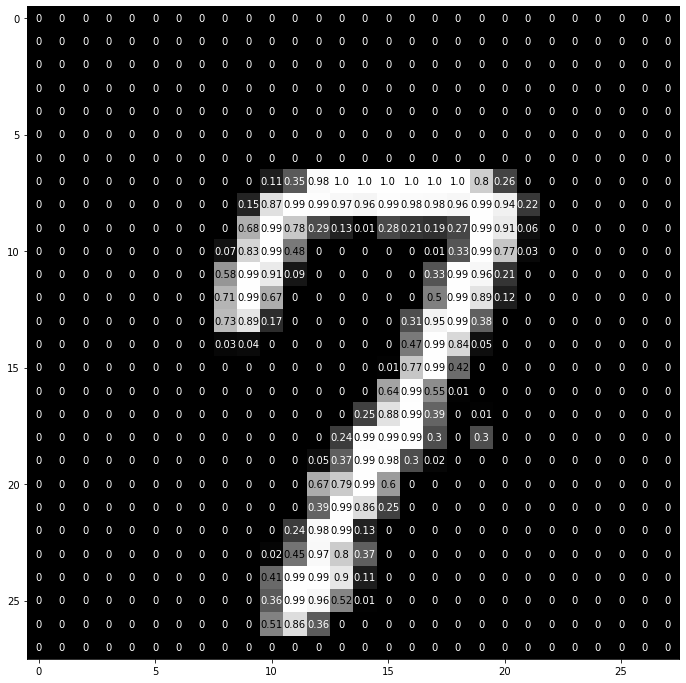

In [28]:
img = images[1]
print(img.shape)
img = np.squeeze(img)
print(img.shape)
#Remove single-dimensional entries from the shape of an array.
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [29]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Recall Inis job is to initialize layers,not to link them with each other at all.
#Noe no softmax here, as we use CrossEntropyLoss which has itincluded
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x


# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [0]:
## TODO: Specify loss and optimization functions

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [31]:
# number of epochs to train the model

#Add in Accuracy laater
n_epochs = 20  # suggest training between 20-50 epochs
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss =valid_loss/len(train_loader.sampler)

    #Print out statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #Save checkpopint
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.947399 	Validation Loss: 0.097691
Validation loss decreased (inf --> 0.097691).  Saving model ...
Epoch: 2 	Training Loss: 0.354709 	Validation Loss: 0.073208
Validation loss decreased (0.097691 --> 0.073208).  Saving model ...
Epoch: 3 	Training Loss: 0.280263 	Validation Loss: 0.060466
Validation loss decreased (0.073208 --> 0.060466).  Saving model ...
Epoch: 4 	Training Loss: 0.230915 	Validation Loss: 0.051574
Validation loss decreased (0.060466 --> 0.051574).  Saving model ...
Epoch: 5 	Training Loss: 0.196015 	Validation Loss: 0.045292
Validation loss decreased (0.051574 --> 0.045292).  Saving model ...
Epoch: 6 	Training Loss: 0.168690 	Validation Loss: 0.039650
Validation loss decreased (0.045292 --> 0.039650).  Saving model ...
Epoch: 7 	Training Loss: 0.150752 	Validation Loss: 0.036832
Validation loss decreased (0.039650 --> 0.036832).  Saving model ...
Epoch: 8 	Training Loss: 0.134537 	Validation Loss: 0.033086
Validation loss decreased (0.03683

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

**`model.eval(`) will set all the layers in your model to evaluation mode.** This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [32]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class - max simply selects the greatest value and ignores the others
    _, pred = torch.max(output, 1)
    print("prediction shape " + str(pred.shape))
    # compare predictions to true label, create a correct list
    #Pred.eq checks if pred is equal to target label - Note this works just as fine as pred.eq(target)
    #we use view_as to ensure that the labels are in the same dimension. In this case all area already in same dimension
    correct = pred.eq(target.data.view_as(pred))
    print("correct shape " +str(correct.shape))
    correct=np.squeeze(correct)
    print("correct shape squeezed " +str(correct.shape))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss

"""
https://jamesmccaffrey.wordpress.com/2019/07/02/the-pytorch-view-reshape-squeeze-and-flatten-functions/
https://deeplizard.com/learn/video/fCVuiW9AFzY
Why do we alwas call np squeeze? Just to ensure tensors can match by removing exessive dimensions

Squeezing a tensor removes the dimensions or axes that have a length of one.
Unsqueezing a tensor adds a dimension with a length of one.

> print(t.reshape([1,12]))
> print(t.reshape([1,12]).shape)
tensor([[1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.]])
torch.Size([1, 12])

> print(t.reshape([1,12]).squeeze())
> print(t.reshape([1,12]).squeeze().shape)
tensor([1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.])
torch.Size([12])

> print(t.reshape([1,12]).squeeze().unsqueeze(dim=0))
> print(t.reshape([1,12]).squeeze().unsqueeze(dim=0).shape)
tensor([[1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.]])
torch.Size([1, 12])

"""


prediction shape torch.Size([20])
correct shape torch.Size([20])
correct shape squeezed torch.Size([20])
prediction shape torch.Size([20])
correct shape torch.Size([20])
correct shape squeezed torch.Size([20])
prediction shape torch.Size([20])
correct shape torch.Size([20])
correct shape squeezed torch.Size([20])
prediction shape torch.Size([20])
correct shape torch.Size([20])
correct shape squeezed torch.Size([20])
prediction shape torch.Size([20])
correct shape torch.Size([20])
correct shape squeezed torch.Size([20])
prediction shape torch.Size([20])
correct shape torch.Size([20])
correct shape squeezed torch.Size([20])
prediction shape torch.Size([20])
correct shape torch.Size([20])
correct shape squeezed torch.Size([20])
prediction shape torch.Size([20])
correct shape torch.Size([20])
correct shape squeezed torch.Size([20])
prediction shape torch.Size([20])
correct shape torch.Size([20])
correct shape squeezed torch.Size([20])
prediction shape torch.Size([20])
correct shape torch.S

'\nhttps://jamesmccaffrey.wordpress.com/2019/07/02/the-pytorch-view-reshape-squeeze-and-flatten-functions/\nhttps://deeplizard.com/learn/video/fCVuiW9AFzY\nWhy do we alwas call np squeeze? Just to ensure tensors can match by removing exessive dimensions\n\nSqueezing a tensor removes the dimensions or axes that have a length of one.\nUnsqueezing a tensor adds a dimension with a length of one.\n\n> print(t.reshape([1,12]))\n> print(t.reshape([1,12]).shape)\ntensor([[1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.]])\ntorch.Size([1, 12])\n\n> print(t.reshape([1,12]).squeeze())\n> print(t.reshape([1,12]).squeeze().shape)\ntensor([1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.])\ntorch.Size([12])\n\n> print(t.reshape([1,12]).squeeze().unsqueeze(dim=0))\n> print(t.reshape([1,12]).squeeze().unsqueeze(dim=0).shape)\ntensor([[1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.]])\ntorch.Size([1, 12])\n\n'

In [33]:
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.072801

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 98% (1013/1032)
Test Accuracy of     3: 98% (995/1010)
Test Accuracy of     4: 97% (961/982)
Test Accuracy of     5: 96% (857/892)
Test Accuracy of     6: 97% (938/958)
Test Accuracy of     7: 97% (1005/1028)
Test Accuracy of     8: 96% (938/974)
Test Accuracy of     9: 95% (966/1009)

Test Accuracy (Overall): 97% (9767/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

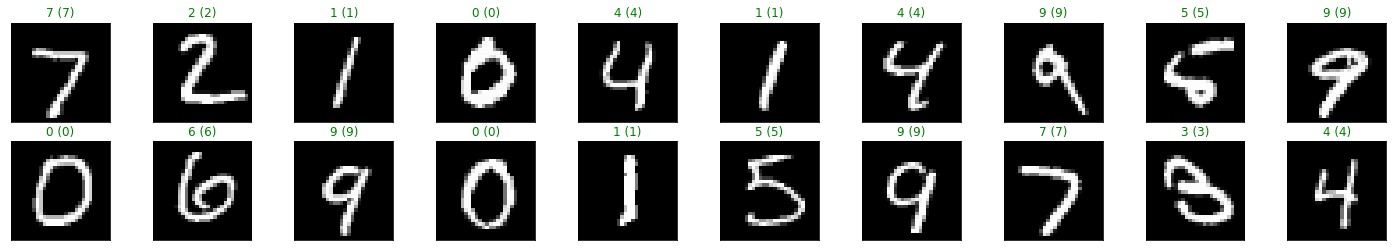

In [34]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))